In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign


dev.txt  test.txt  train.txt


In [ ]:
curr_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
def get_lines(file_path):
  with open(file_path, "r") as f:
    return f.readlines()

In [ ]:
get_lines(curr_dir + '/train.txt')

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_files(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []


  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
train_samples = preprocess_files(curr_dir + '/train.txt')
test_samples = preprocess_files(curr_dir + '/test.txt')
val_samples = preprocess_files(curr_dir + '/dev.txt')

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [ ]:
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

In [ ]:
train_df['target'].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder as le
le = le()
train_labels_encoded = le.fit_transform(train_df['target'].to_numpy())
test_labels_encoded = le.fit_transform(test_df['target'].to_numpy())
val_labels_encoded = le.fit_transform(val_df['target'].to_numpy())

In [ ]:
from sklearn.preprocessing import OneHotEncoder as ohe

train_labels_ohe = ohe(sparse=False).fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
test_labels_ohe = ohe(sparse=False).fit_transform(test_df['target'].to_numpy().reshape(-1, 1))
val_labels_ohe = ohe(sparse=False).fit_transform(val_df['target'].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
def evaluate_model(model, val_sentences, val_targets):
  model_accuracy = accuracy_score(val_targets, model.predict(val_sentences))
  model_f1score = f1_score(val_targets, model.predict(val_sentences), average='weighted')
  model_recall = recall_score(val_targets, model.predict(val_sentences), average='weighted')
  model_results = {"accuracy" : model_accuracy,
                   "f1score" : model_f1score,
                   "recall" : model_recall}

  return model_results

In [ ]:
# Model_0 BASELINE
train_sentences = train_df['text'].tolist()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [ ]:
base_results = evaluate_model(model_0, train_sentences, train_labels_encoded)
base_results

{'accuracy': 0.7516829593423684,
 'f1score': 0.734085177322999,
 'recall': 0.7516829593423684}

(array([1.25846e+05, 4.78220e+04, 5.37600e+03, 7.86000e+02, 1.46000e+02,
        3.20000e+01, 1.90000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([  1. ,  30.5,  60. ,  89.5, 119. , 148.5, 178. , 207.5, 237. ,
        266.5, 296. ]),
 <BarContainer object of 10 artists>)

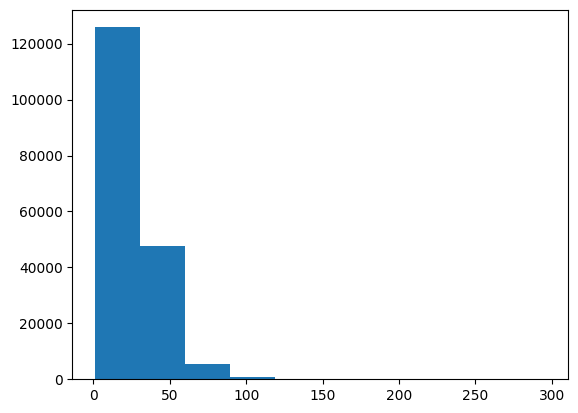

In [ ]:
sentence_len = [len(sentence.split()) for sentence in train_sentences]
plt.hist(sentence_len)

In [ ]:
max_tokens = 6800
output_sentence_length = 60

from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_sentence_length)

text_vectorizer.adapt(train_sentences)

In [ ]:
len(text_vectorizer.get_vocabulary())

6800

In [ ]:
from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim = max_tokens,
                      output_dim = 128,
                      mask_zero = True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_ohe))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['target'], test_labels_ohe))
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['target'], val_labels_ohe))

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# model_1 1D Conv

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam())

In [ ]:
model_1.fit(train_dataset,
            epochs=5,
            steps_per_epoch = 0.1*len(train_dataset),
            validation_data=val_dataset,
            validation_steps = 0.1*len(val_dataset))

Epoch 1/5
562/562 [==============================] - 18s 28ms/step - loss: 0.9524 - accuracy: 0.6213 - val_loss: 1.5276 - val_accuracy: 0.3286
Epoch 2/5
562/562 [==============================] - 15s 27ms/step - loss: 0.6963 - accuracy: 0.7396 - val_loss: 1.5317 - val_accuracy: 0.3286
Epoch 3/5
562/562 [==============================] - 16s 29ms/step - loss: 0.6535 - accuracy: 0.7603 - val_loss: 1.4828 - val_accuracy: 0.3286
Epoch 4/5
562/562 [==============================] - 20s 36ms/step - loss: 0.6205 - accuracy: 0.7735 - val_loss: 1.5087 - val_accuracy: 0.3286
Epoch 5/5
562/562 [==============================] - 15s 26ms/step - loss: 0.6119 - accuracy: 0.7817 - val_loss: 1.4724 - val_accuracy: 0.3286


In [ ]:
evaluate_model(model_1, val_df['text'].tolist(), val_labels_ohe)

945/945 [==============================] - 8s 9ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [ ]:
# Model_2: Uses USE from Tensorflow Hub, which takes care of encoding and tokenizing

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(inputs)
x = tf.keras.layers.Dense(100, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(5, activation = 'softmax')(x)
model_2 = tf.keras.Model(inputs,outputs)

In [ ]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam())


In [ ]:
model_2.fit(train_dataset,
            epochs=5,
            steps_per_epoch = 0.1*len(train_dataset),
            validation_data=val_dataset,
            validation_steps = 0.1*len(val_dataset))

Epoch 1/5
562/562 [==============================] - 16s 19ms/step - loss: 0.9271 - accuracy: 0.6433 - val_loss: 1.7105 - val_accuracy: 0.1503
Epoch 2/5
562/562 [==============================] - 14s 24ms/step - loss: 0.7740 - accuracy: 0.6991 - val_loss: 1.6423 - val_accuracy: 0.1503
Epoch 3/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7581 - accuracy: 0.7100 - val_loss: 1.5803 - val_accuracy: 0.1503
Epoch 4/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7267 - accuracy: 0.7206 - val_loss: 1.7742 - val_accuracy: 0.1503
Epoch 5/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7338 - accuracy: 0.7199 - val_loss: 1.7064 - val_accuracy: 0.1503


In [ ]:
evaluate_model(model_2, val_df['text'].tolist(), val_labels_ohe)

945/945 [==============================] - 12s 13ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets